In [1]:
from functools import cached_property
from mlflux.predictor import FluxANNs
import torch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from mlflux.datafunc import data_split_psd
from mlflux.ann import RealFluxDataset

import pickle

%load_ext autoreload
%autoreload 3

In [2]:
''' An ad-hoc function for reading in an ensemble of ANNs. 
    N: number of ensemble member 
    filename: the shared part of saved model name
    X: inputs (should already be in torch tensor of size Nsample*Nfeature '''

# TODO: figure out how to make this function know about Fluxdiff
import torch
import pickle
from mlflux.predictor import Fluxdiff
from scipy.stats import wasserstein_distance

In [3]:
''' Common data set and weights shared between fluxes. '''
def sample_weights(x):
    return np.where(x > 18, 1.0, 1.0)
psd = xr.load_dataset('../../data/Processed/psd_wave.nc')

In [6]:
def ensem_score(modelname, ds, keys, N=6):
    
    # Pick out the variables needed
    vd = RealFluxDataset(ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], 
                         weightfunc=sample_weights)
    res_mean = []; res_var = []; di = []   
    
    # sample from standard Gaussian for distance
    s = np.random.normal(0, 1, len(vd.X)) 
    
    for i in range(0,N):
        filename = modelname + "%g.p" %(i+1)
        with open(filename, "rb") as input_file:
            model = pickle.load(input_file)
    
        error = model.pred_mean(vd.X).detach().numpy() - vd.Y.detach().numpy()
        error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5
        res_mean.append(error_norm.mean())
        res_var.append(error_norm.std())
        di.append(wasserstein_distance(error_norm.squeeze(), s))

    return res_mean, res_var, di

#### Momentum flux

In [7]:
# modelname = '/home/jw8736/mlflux/saved_model/' + 'full_anns_diff_momentum_3layers_split' # older version
modelname = '/home/jw8736/mlflux/saved_model/one_output_anns/' + 'Flux41_momentum_3layers_split'
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
ds = psd
res_mean, res_var, di = ensem_score(modelname, ds, keys, N=6)

Text(0.5, 0, 'Model number')

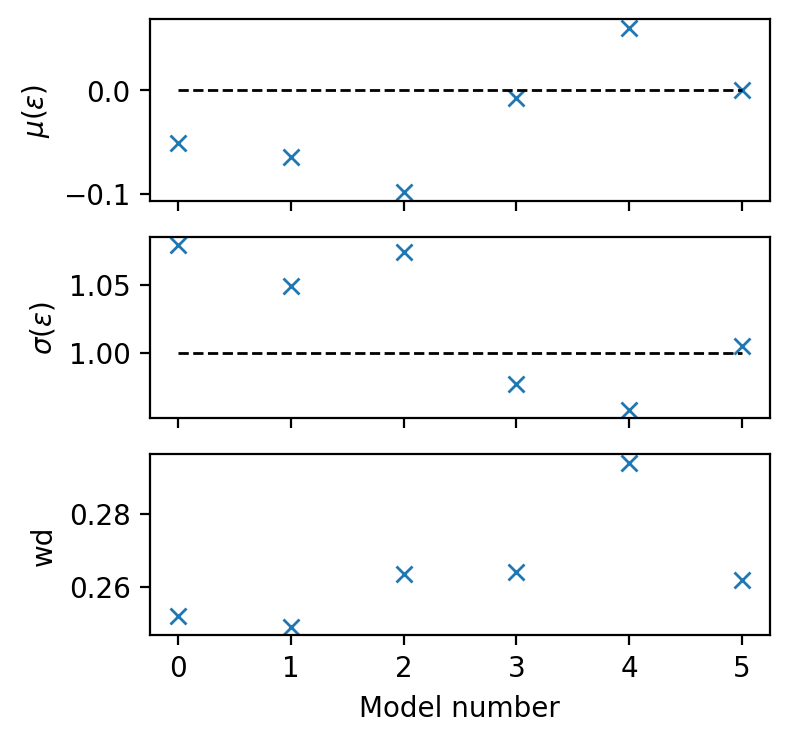

In [8]:
fig, axes = plt.subplots(3,1,sharex=True, figsize=[4,4], dpi=200)
axes[0].plot(res_mean, 'x')
# axes[0].set_ylim([-0.1,0.2])
axes[0].hlines(y=0., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[1].plot(res_var, 'x')
# axes[1].set_ylim([0,4])
axes[1].hlines(y=1., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[2].plot(di, 'x')
# axes[2].set_ylim([0,1.5])

axes[0].set_ylabel('$\mu(\epsilon)$')
axes[1].set_ylabel('$\sigma(\epsilon)$')
axes[2].set_ylabel('wd')
plt.xlabel('Model number')

#### Sensible heat

In [9]:
# modelname = '/home/jw8736/mlflux/saved_model/' + 'full_anns_diff_sensible_3layers_split' # older version
modelname = '/home/jw8736/mlflux/saved_model/one_output_anns/' + 'Flux41_sensible_3layers_split'
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
res_mean, res_var, di = ensem_score(modelname, keys, N=6)

Text(0.5, 0, 'Model number')

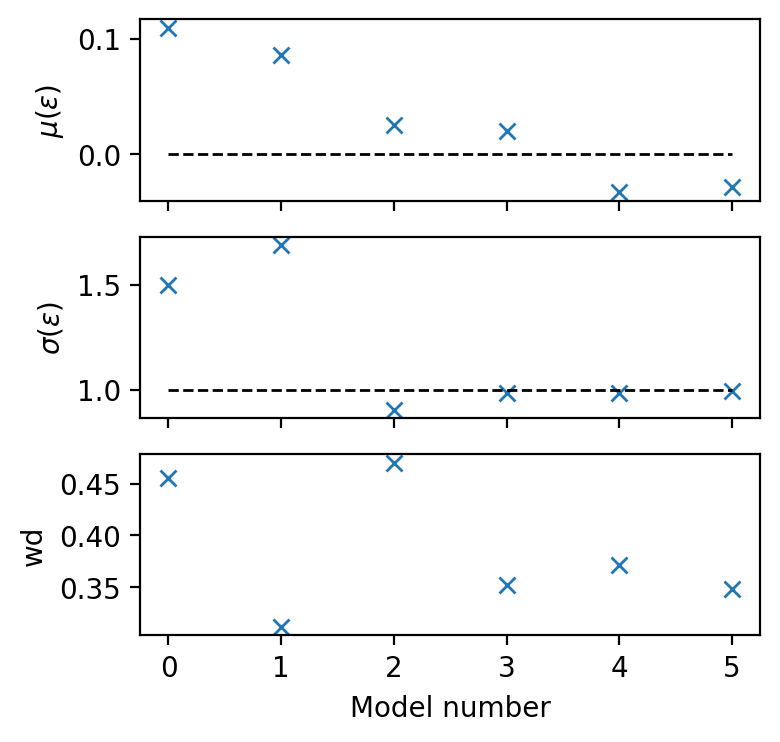

In [10]:
fig, axes = plt.subplots(3,1,sharex=True, figsize=[4,4], dpi=200)
axes[0].plot(res_mean, 'x') 
# axes[0].set_ylim([-0.1,0.2])
axes[0].hlines(y=0., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[1].plot(res_var, 'x')
# axes[1].set_ylim([0,4])
axes[1].hlines(y=1., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[2].plot(di, 'x')
# axes[2].set_ylim([0,1.5])

axes[0].set_ylabel('$\mu(\epsilon)$')
axes[1].set_ylabel('$\sigma(\epsilon)$')
axes[2].set_ylabel('wd')
plt.xlabel('Model number')

#### latent heat

In [11]:
# modelname = '/home/jw8736/mlflux/saved_model/' + 'full_anns_diff_latent_3layers_split'
modelname = '/home/jw8736/mlflux/saved_model/one_output_anns/' + 'Flux41_latent_3layers_split'
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
res_mean, res_var, di = ensem_score(modelname, keys, N=6)

Text(0.5, 0, 'Model number')

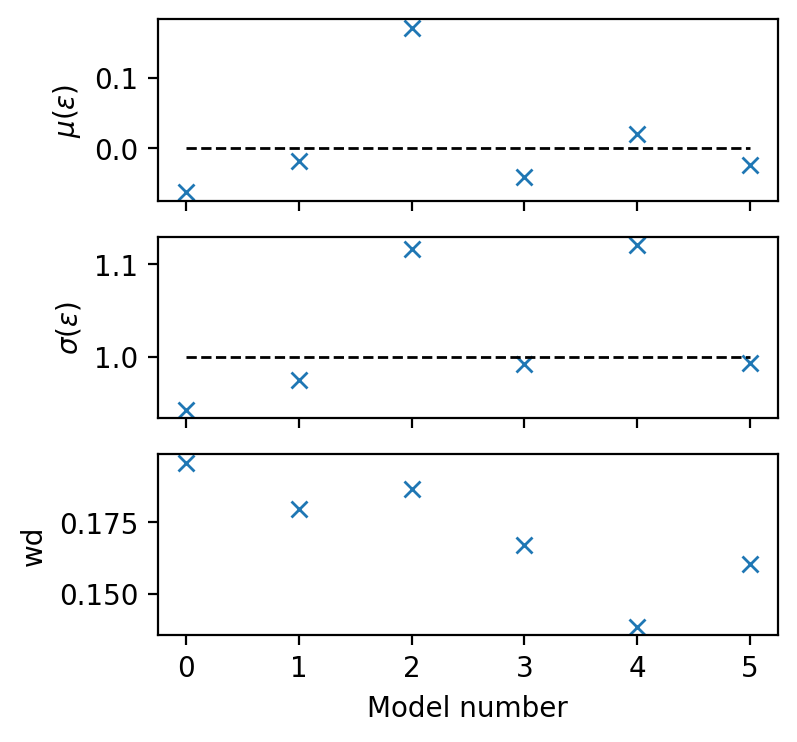

In [12]:
fig, axes = plt.subplots(3,1,sharex=True, figsize=[4,4], dpi=200)
axes[0].plot(res_mean, 'x') 
# axes[0].set_ylim([-0.1,0.2])
axes[0].hlines(y=0., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[1].plot(res_var, 'x')
# axes[1].set_ylim([0,4])
axes[1].hlines(y=1., xmin=0, xmax=5, ls='--', linewidth=1, color='k')
axes[2].plot(di, 'x')
# axes[2].set_ylim([0,1.5])

axes[0].set_ylabel('$\mu(\epsilon)$')
axes[1].set_ylabel('$\sigma(\epsilon)$')
axes[2].set_ylabel('wd')
plt.xlabel('Model number')

### Visualize stochastic residual distribution


(0.0001, 1.0)

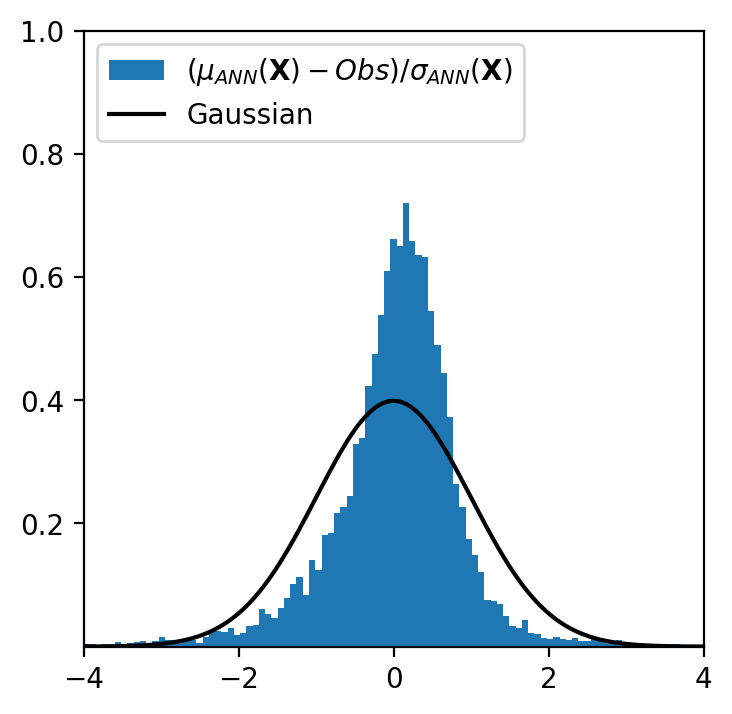

In [10]:
''' PDF compared to Gaussian. Momentum. '''
fig = plt.figure(figsize=(4,4),dpi=200)
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
# modelname = '/home/jw8736/mlflux/saved_model/' + 'full_anns_diff_momentum_3layers_split'
modelname = '/home/jw8736/mlflux/saved_model/one_output_anns/' + 'Flux41_momentum_3layers_split'

i = 5
filename = modelname + "%g.p" %(i+1)
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)

ds = psd.where(psd.U<15, drop=True)
vd = RealFluxDataset(ds, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)
error = model.pred_mean(vd.X).detach().numpy() - vd.Y.detach().numpy()
error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5


plt.hist(error_norm, bins=np.linspace(-4, 4, 100), density=True, 
         label='$(\mu_{ANN}(\mathbf{X}) - Obs)/\sigma_{ANN}(\mathbf{X})$')

mu = 0      # mean
sigma = 1   # standard deviation

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)

plt.plot(x, y, color='k', label='Gaussian')
plt.legend(loc='upper left')
plt.xlim([-4,4]); plt.ylim([0.0001,1])

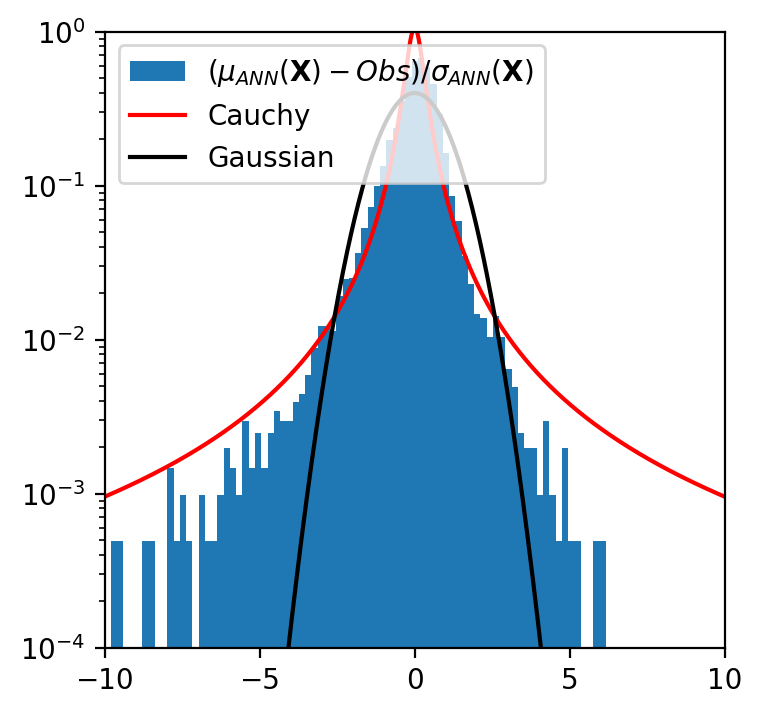

In [42]:
''' PDF compared to Gaussian. Momentum. '''

keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)

# modelname = '/home/jw8736/mlflux/saved_model/' + 'full_anns_diff_momentum_3layers_split'
modelname = '/home/jw8736/mlflux/saved_model/one_output_anns/' + 'Flux41_momentum_3layers_split'

i = 5
filename = modelname + "%g.p" %(i+1)
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)
    
error = model.pred_mean(vd.X).detach().numpy() - vd.Y.detach().numpy()
error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5

fig = plt.figure(figsize=(4,4),dpi=200)
plt.hist(error_norm, bins=np.linspace(-10, 10, 100), density=True, 
         label='$(\mu_{ANN}(\mathbf{X}) - Obs)/\sigma_{ANN}(\mathbf{X})$')

mu = 0      # mean
sigma = 1   # standard deviation

x = np.linspace(mu - 10*sigma, mu + 10*sigma, 1000)
y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)

plt.plot(x, y_, color='r', label='Cauchy')


plt.plot(x, y, color='k', label='Gaussian')
plt.legend(loc='upper left')
plt.xlim([-10,10]); plt.ylim([0.0001,1])
plt.yscale('log')

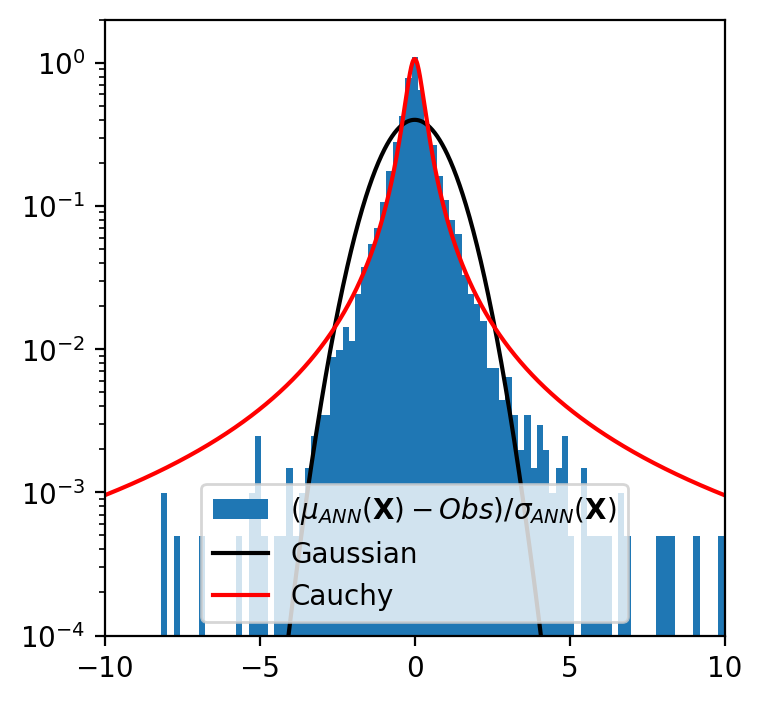

In [40]:
''' PDF compared to Gaussian. Sensible heat. '''

keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hsc'], 'bkeys':['hsb']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)

# modelname = '/home/jw8736/mlflux/saved_model/' + 'full_anns_diff_sensible_3layers_split'
modelname = '/home/jw8736/mlflux/saved_model/one_output_anns/' + 'Flux41_sensible_3layers_split'

i = 3
filename = modelname + "%g.p" %(i+1)
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)
    
error = model.pred_mean(vd.X).detach().numpy() - vd.Y.detach().numpy()
error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5

fig = plt.figure(figsize=(4,4),dpi=200)
plt.hist(error_norm, bins=np.linspace(-10, 10, 100), density=True, 
         label='$(\mu_{ANN}(\mathbf{X}) - Obs)/\sigma_{ANN}(\mathbf{X})$')

mu = 0      # mean
sigma = 1   # standard deviation

x = np.linspace(mu - 10*sigma, mu + 10*sigma, 1000)
y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)
y_ = 1/((np.pi*0.3)*(1+(x/0.3)**2))


plt.plot(x, y, color='k', label='Gaussian')
plt.plot(x, y_, color='r', label='Cauchy')
plt.legend()

# plt.xlim([-4,4]); plt.ylim([0,2])
plt.xlim([-10,10]); plt.ylim([0.0001,2])
plt.yscale('log')

(0.0, 0.6)

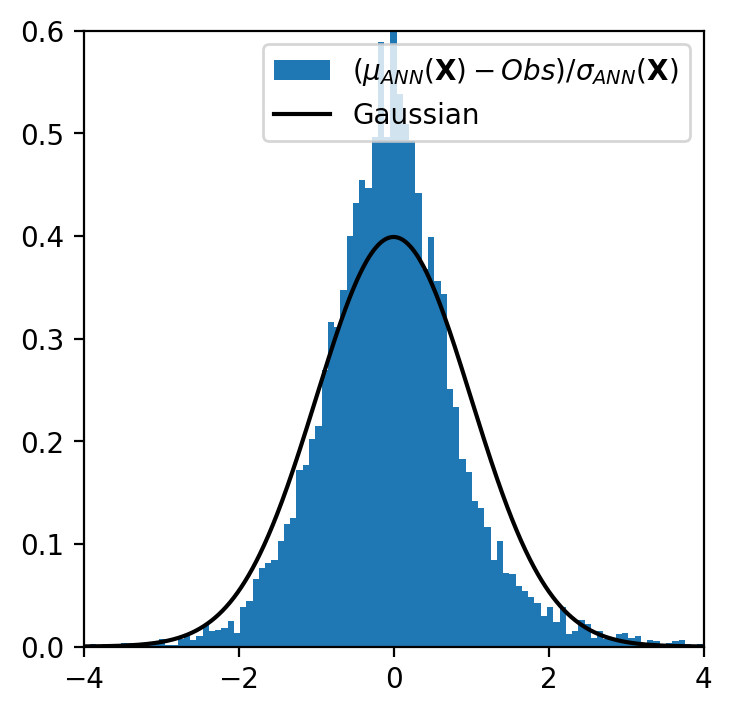

In [22]:
''' PDF compared to Gaussian. Latent heat. '''

keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['hlc'], 'bkeys':['hlb']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)

# modelname = '/home/jw8736/mlflux/saved_model/' + 'full_anns_diff_latent_3layers_split'
modelname = '/home/jw8736/mlflux/saved_model/one_output_anns/' + 'Flux41_latent_3layers_split'

i = 5
filename = modelname + "%g.p" %(i+1)
with open(filename, "rb") as input_file:
    model = pickle.load(input_file)
    
error = model.pred_mean(vd.X).detach().numpy() - vd.Y.detach().numpy()
error_norm = error/model.pred_var(vd.X).detach().numpy()**0.5

fig = plt.figure(figsize=(4,4),dpi=200)
plt.hist(error_norm, bins=np.linspace(-4, 4, 100), density=True, 
         label='$(\mu_{ANN}(\mathbf{X}) - Obs)/\sigma_{ANN}(\mathbf{X})$')

mu = 0      # mean
sigma = 1   # standard deviation

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)

plt.plot(x, y, color='k', label='Gaussian')
plt.legend()
plt.xlim([-4,4]); plt.ylim([0,0.6])

In [ ]:
''' Q-Q plot '''

import scipy.stats as stats
plt.figure(figsize=[4,4], dpi=200)

# Generate Q-Q plot

stats.probplot(error_norm.squeeze(), dist="norm", plot=plt)

# Display the plot
plt.title('momentum (predict - measure)')
plt.xlabel('normal')
plt.ylabel('error dist.')
# plt.ylim([-2,2]); plt.xlim([-2,2])
# plt.xticks([-4,-2,0,2,4]); plt.yticks([-4,-2,0,2,4])
plt.show()

### Visualize bulk formula stochastic residuals

(0.0, 0.6)

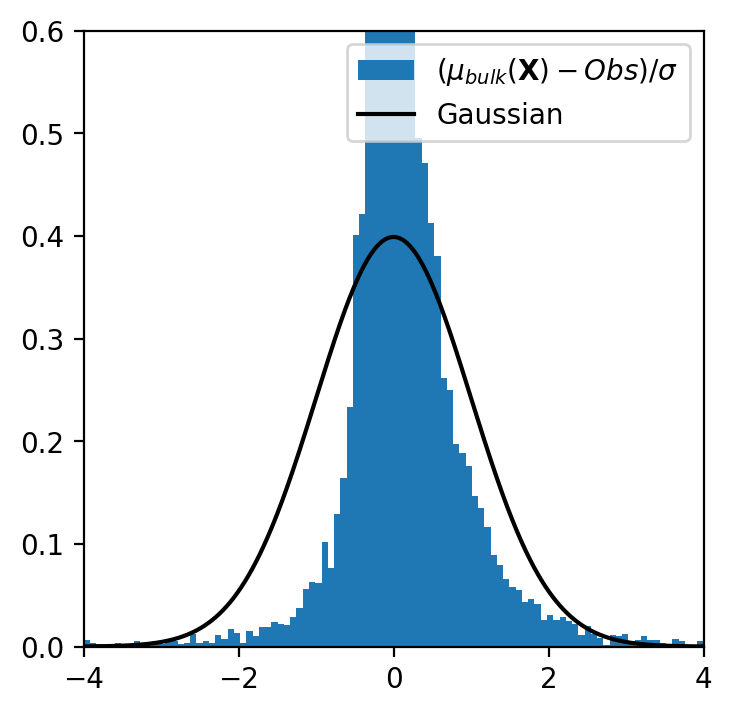

In [8]:
''' PDF compared to Gaussian. Momentum. '''

keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)

error = (vd.Y - vd.Bulk).numpy()
error_norm = error/np.var(error)**0.5

fig = plt.figure(figsize=(4,4),dpi=200)
plt.hist(error_norm, bins=np.linspace(-4, 4, 100), density=True, 
         label='$(\mu_{bulk}(\mathbf{X}) - Obs)/\sigma$')

mu = 0      # mean
sigma = 1   # standard deviation

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
y = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu)/sigma)**2)

plt.plot(x, y, color='k', label='Gaussian')
plt.legend()
plt.xlim([-4,4]); plt.ylim([0,0.6])

In [5]:
keys = {'ikeys':['U','tsea','tair','rh'], 'okeys':['taucx'], 'bkeys':['taubx']}
vd = RealFluxDataset(psd, input_keys=keys['ikeys'], output_keys=keys['okeys'], bulk_keys=keys['bkeys'], weightfunc=sample_weights)


In [13]:
error

tensor([[-0.0712],
        [ 0.0338],
        [-0.2139],
        ...,
        [-0.0284],
        [-0.0093],
        [-0.0168]])